# Beer Data Analysis
#### jhh283, sjh293

### Abstract


In [1]:
import os

from IPython.display import display, Image
from PIL import Image as PILImage

def files_at_relpath(rel_path):
    return [os.path.join(rel_path, f) for f in os.listdir(rel_path)]


def display_images(img_path, **kwargs):
    scale = kwargs.get('scale')
    if scale is not None:
        kwargs.pop('scale', None)
    kwargs.pop("key", None)
    files = files_at_relpath(img_path)
    for filename in files:
        try:
            if scale is None:
                display(Image(filename=filename, **kwargs))
            else:
                w, h = None, None
                with PILImage.open(filename) as imgfile:
                    w, h = imgfile.size
                kwargs['width'] = float(w) * scale
                kwargs['height'] = float(h) * scale
                display(Image(filename=filename, **kwargs))
        except ValueError as e:
            continue

## RateBeer Profiles

### Profile for user 'MiP' as of April 2009 and August 2009 (respectively)
* 2008: https://web.archive.org/web/20090425001049/http://www.ratebeer.com/View-User-10185.htm
* 2009: https://web.archive.org/web/20090822202711/http://www.ratebeer.com/View-User-10185.htm

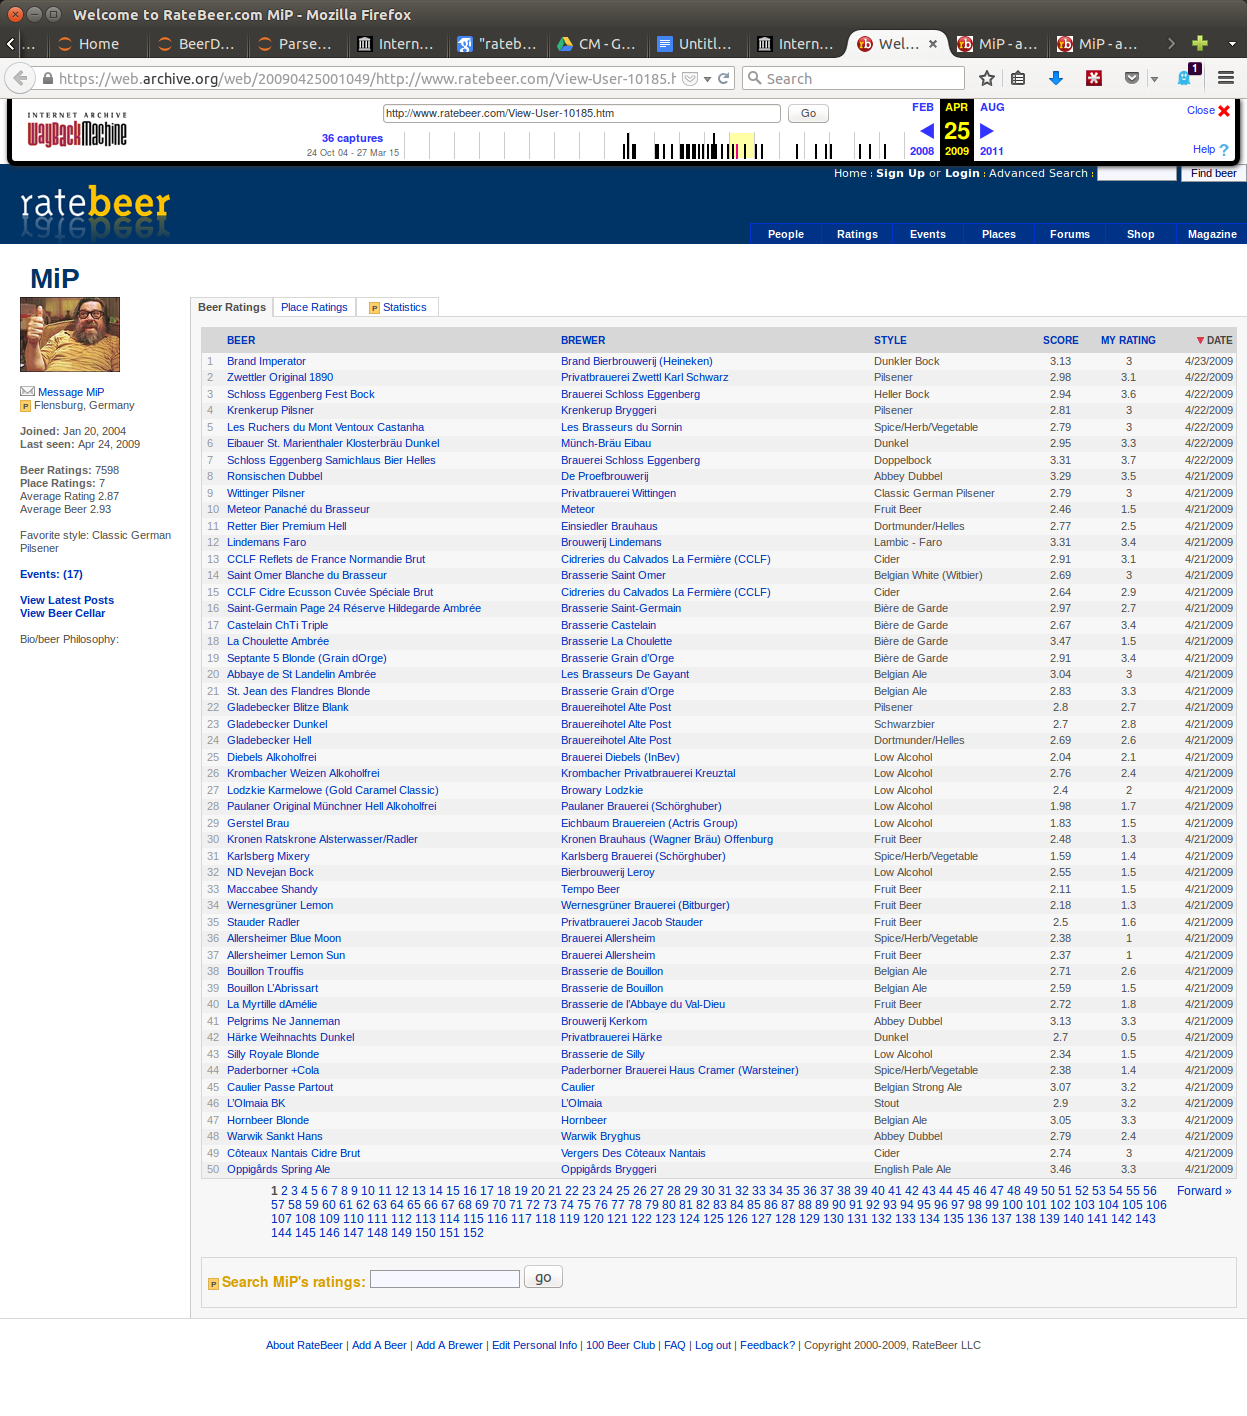

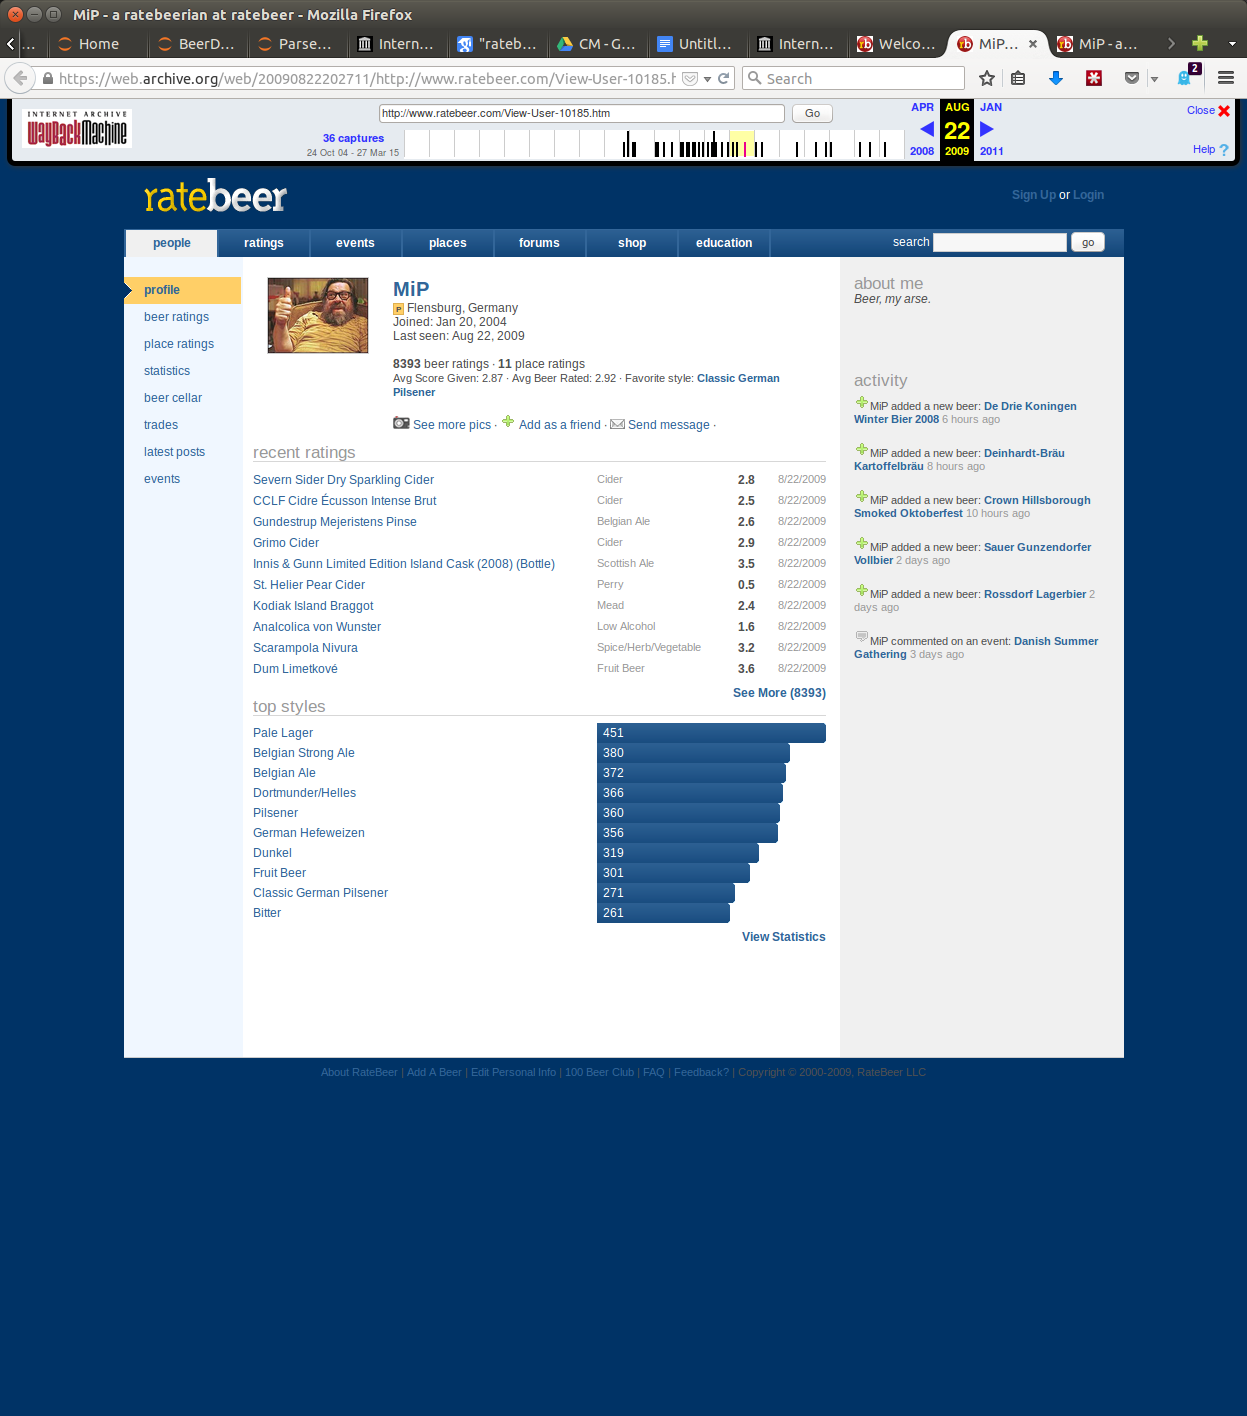

In [2]:
display_images('images/ratebeer/profiles-MiP/', scale=0.7)

## Analysis

In [105]:
%matplotlib inline

import json
from itertools import groupby
from collections import defaultdict
from datetime import date

import matplotlib.pyplot as plt
import matplotlib.dates as mdates

import numpy as np

plt.style.use('bmh')

### Helper functions

In [27]:
def parse_json(filename, normalize=True):
    with open(filename) as f:
        for line in f:
            out = json.loads(line, encoding='latin-1')
            if normalize:
                temp = {}
                for key in out:
                    try:
                        key = clean_unicode(key)
                    except:
                        key = key
                    try:
                        temp[key] = clean_unicode(out[key])
                    except:
                        temp[key] = out[key]
                out = temp
            yield out
    f.close()

In [81]:
# via http://matplotlib.org/examples/pylab_examples/finance_work2.html

def moving_average(x, n, type='simple'):
    """
    compute an n period moving average.

    type is 'simple' | 'exponential'

    """
    x = np.asarray(x)
    if type=='simple':
        weights = np.ones(n)
    else:
        weights = np.exp(np.linspace(-1., 0., n))

    weights /= weights.sum()


    a =  np.convolve(x, weights, mode='full')[:len(x)]
    a[:n] = a[n]
    return a

### Load RateBeer dataset

In [28]:
reviews = []
for i in parse_json('data/reduced_data.txt'):
    reviews.append(i)
print 'Total reviews in universe: %d' % len(reviews)

### Group reviews by date

In [90]:
sorted_reviews = sorted(reviews, key=lambda r: r.get('review/timeUnix'))
# print sorted_reviews[0:2]
review_by_date = {}
for key, group in groupby(sorted_reviews, lambda r: date.fromtimestamp(r.get('review/timeUnix'))):
    review_by_date[key] = len(list(group))

In [91]:
print sorted_reviews[0:2]

[{u'review/appearance': 0.6, u'review/timeUnix': 1225497600, u'beer/style': u'Stout', u'review/palate': 0.6, u'review/taste': 0.7, u'beer/name': u'Barley Island Beastie Barrel Stout', u'beer/ABV': 6.0, u'beer/beerId': u'91689', u'beer/brewerId': u'3228', u'review/timeStruct': {u'isdst': 0, u'mday': 1, u'hour': 0, u'min': 0, u'sec': 0, u'mon': 11, u'year': 2008, u'yday': 306, u'wday': 5}, u'review/overall': 0.8, u'review/text': u'From a 12oz bottle - Pours pitch black in color with small caramel colored.  Slightly below average carbonation.  Smells of roasted malts and some coffee.   First sip is smooth with roasted malts and coffee leading the way.  There is a fairly nice malt backbone. Dark chocolate notes also presence. Very nice and drinkable.  Some bourbon in the finish.', u'user/profileName': u'ATLBeerDog', u'review/aroma': 0.6}, {u'review/appearance': 0.6, u'review/timeUnix': 1225497600, u'beer/style': u'Altbier', u'review/palate': 0.6, u'review/taste': 0.5, u'beer/name': u'Eick 

### Plot of total RateBeer reviews between November 1, 2008 and November 1, 2009

In [137]:
dates = sorted(review_by_date.keys())
review_counts = [review_by_date[k] for k in dates]
ma_days = 45
ma = moving_average(review_counts, ma_days)

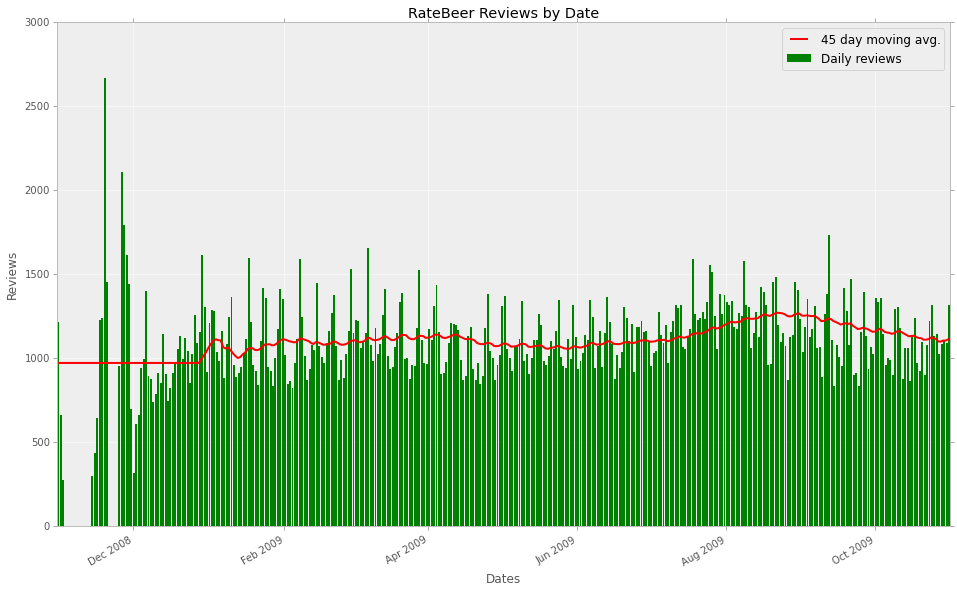

In [138]:
fig, axes = plt.subplots(1, figsize=(16, 10))
axes.bar(dates, review_counts, color='green', linewidth=0, label='Daily reviews')
axes.plot(dates, ma, 'r', label=('%d day moving avg.' % ma_days))
fig.autofmt_xdate()
axes.set_title('RateBeer Reviews by Date')
axes.set_xlabel('Dates')
axes.set_ylabel('Reviews')
axes.fmt_xdata = mdates.DateFormatter('%Y-%m-%d')
handles, labels = axes.get_legend_handles_labels()
axes.legend(handles, labels)

### Stuff

In [102]:
user_keyfunc = lambda r: r.get('user/profileName')

def month_keyfunc(review):
    # Return the first day of the month for any day in a month
    review_date = date.fromtimestamp(review.get('review/timeUnix'))
    return date(review_date.year, review_date.month, 1)

monthly_user_count = {}
for key, group in groupby(sorted_reviews, month_keyfunc):
    user_sorted = sorted(group, key=user_keyfunc)
    monthly_user_count[key] = len(list(groupby(user_sorted, user_keyfunc)))

In [126]:
months = sorted(monthly_user_count.keys())
user_counts = [monthly_user_count[k] for k in monthly_user_count.keys()]
for i in range(len(months)):
    print '%s - %s' % (months[i], "{:,}".format(user_counts[i]))

2008-10-01 - 2,105
2008-11-01 - 2,096
2008-12-01 - 2,158
2009-01-01 - 1,363
2009-02-01 - 2,046
2009-03-01 - 415
2009-04-01 - 2,070
2009-05-01 - 1,845
2009-06-01 - 2,105
2009-07-01 - 2,074
2009-08-01 - 2,157
2009-09-01 - 2,121
2009-10-01 - 2,139


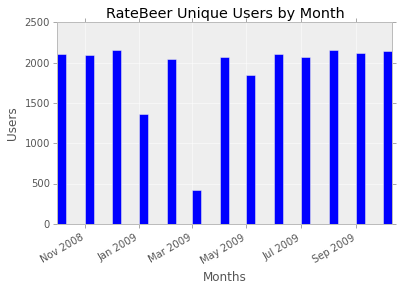

In [128]:
width = 0.35
fig, axes = plt.subplots(1)
axes.bar(months, user_counts, width=10)
fig.autofmt_xdate()
axes.set_title('RateBeer Unique Users by Month')
axes.set_xlabel('Months')
axes.set_ylabel('Users')
axes.fmt_xdata = mdates.DateFormatter('%Y-%m')